#Modules 2, 3 and 4 - Project

In [ ]:
import gym
import pandas as pd
import torch

env = gym.make("Taxi-v3").env

env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [ ]:
# exploit vs explore to find action
# Start with 70% random actions to explore the environment
# And with time, using decay to shift to more optimal actions learned from experience

egreedy = 0.7
egreedy_final = 0.1
egreedy_decay = 0.999
egreedy_total = []
steps_total = []

In [ ]:
#6 possible actions and 500 possible states

Q = torch.zeros([500, 6])
Q

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [ ]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [ ]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
egreedy_total = []

done = False
step = 0

while not done:

    random_for_egreedy = torch.rand(1)[0]

    if random_for_egreedy > egreedy:      
        random_values = Q[state] + torch.rand(1,6) / 1000      
        action = torch.max(random_values,1)[1][0]  
        action = action.item()
    else:
        action = env.action_space.sample()
            
    if egreedy > egreedy_final:
        egreedy *= egreedy_decay

    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    

    egreedy_total.append(egreedy)
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1114
Penalties incurred: 367


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

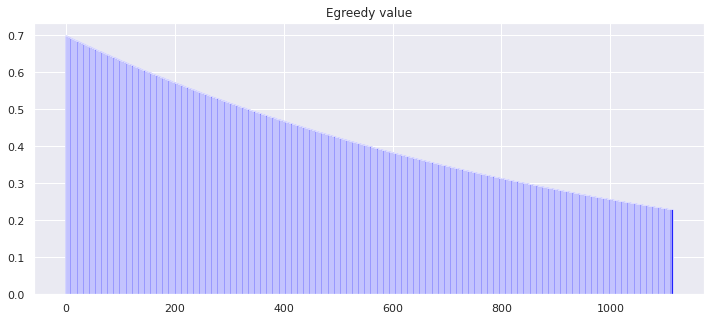

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Egreedy value")
plt.bar(torch.arange(len(egreedy_total)), egreedy_total, alpha=0.6, color='blue', width=5)
plt.show()

In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        #sleep(.1) 

In [ ]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1114
State: 0
Action: 5
Reward: 20


In [ ]:
def show_rewards_over_time(timesteps, cumulative_rewards, frames):

  cumulative_reward = 0

  for i, frame in enumerate(frames):
      timesteps.append(i)
      cumulative_reward += frame['reward']
      cumulative_rewards.append(cumulative_reward)

  plt.plot(timesteps, cumulative_rewards)
  plt.legend('Reward', ncol=2, loc='upper left');

Cumulative reward before training keeps decreasing over time.


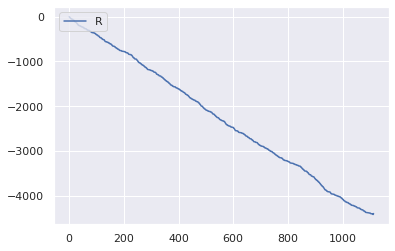

In [ ]:
timesteps = []
cumulative_rewards = []

print("Cumulative reward before training keeps decreasing over time.")

show_rewards_over_time(timesteps, cumulative_rewards, frames)

#Training our model using Q-Learning

In [ ]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []
steps_total = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        step += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        steps_total.append(step)
        step = 0

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: user 1min 10s, sys: 14.6 s, total: 1min 25s
Wall time: 1min 13s


In [ ]:
q_table[328]

array([ -2.39913543,  -2.27325184,  -2.40416785,  -2.35775361,
       -10.80692507, -11.20454422])

In [ ]:
q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.41837065,  -2.3639511 ,  -2.41837065,  -2.36395108,
         -2.27325184, -11.36395053],
       [ -1.870144  ,  -1.45024001,  -1.87014399,  -1.45024001,
         -0.7504    , -10.45023872],
       ...,
       [ -1.0457663 ,   0.41599999,  -1.13712957,  -1.25684087,
         -5.72866146,  -6.539345  ],
       [ -2.15805802,  -2.12204743,  -2.14597216,  -2.1220433 ,
         -8.18593458,  -6.31135086],
       [  3.96097133,   1.36975014,   4.38730485,  11.        ,
         -1.85472498,  -2.25208762]])

In [ ]:
actions_df = pd.DataFrame(q_table, columns=['south', 'north', 'east', 'west', 'pickup', 'dropoff'])

In [ ]:
states = np.arange(1, 501)

states_df = pd.DataFrame(states, columns = ['state'])

In [ ]:
qtable_df = states_df.join(actions_df)

In [ ]:
qtable_df = qtable_df.drop(columns = ['dropoff'])

In [ ]:
qtable_df

,state,south,north,east,west,pickup
0,1,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,-2.418371,-2.363951,-2.418371,-2.363951,-2.273252
2,3,-1.870144,-1.450240,-1.870144,-1.450240,-0.750400
3,4,-2.363951,-2.273252,-2.363951,-2.273252,-2.122086
4,5,-2.496192,-2.496704,-2.496192,-2.496777,-9.492856
...,...,...,...,...,...,...
495,496,0.000000,0.000000,0.000000,0.000000,0.000000
496,497,-2.143455,-2.122071,-2.169595,-2.122071,-7.646871
497,498,-1.045766,0.416000,-1.137130,-1.256841,-5.728661
498,499,-2.158058,-2.122047,-2.145972,-2.122043,-8.185935


In [ ]:
qtable_df.to_csv("qtable.csv")

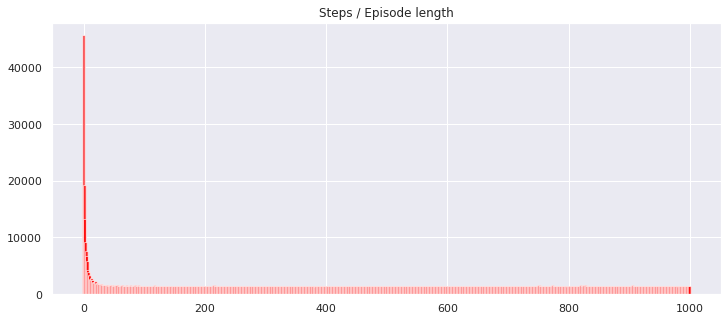

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Steps / Episode length")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='red', width=5)
plt.show()

#Evaluating agent performance:

In [ ]:
"""Evaluate agent's performance after Q-learning"""

frames_res = []
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        frames_res.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
          }
        )

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Results after 100 episodes:
Average timesteps per episode: 12.56
Average penalties per episode: 0.0


Cumulative reward after training keeps increasing over time.


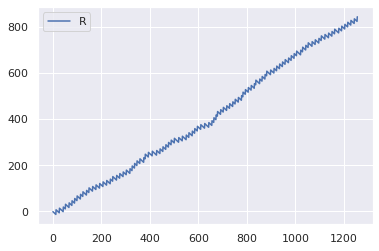

In [ ]:
timesteps = []
cumulative_rewards = []

print("Cumulative reward after training keeps increasing over time.")

show_rewards_over_time(timesteps, cumulative_rewards, frames_res)

In [ ]:
timesteps_df = pd.DataFrame(timesteps, columns=['Timestep'])

rewards_df = pd.DataFrame(cumulative_rewards , columns=['Cumulative Rewards'])

cumulative_rewards_df = timesteps_df.join(rewards_df)

In [ ]:
cumulative_rewards_df

,Timestep,Cumulative Rewards
0,0,-1
1,1,-2
2,2,-3
3,3,-4
4,4,-5
...,...,...
1251,1251,827
1252,1252,826
1253,1253,825
1254,1254,824


In [ ]:
print_frames(frames_res)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1256
State: 410
Action: 5
Reward: 20
